# Prepare Custom Dataset (10 Big Cats of the Wild - Image Classification)
### URL: https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification

In [12]:
import torchvision
import numpy as np
import torch
import glob
import os

train_path = glob.glob('data/Wild Cats/train/**/*.jpg')
test_path = glob.glob('data/Wild Cats/test/**/*.jpg')
target_names = np.sort(os.listdir('data/Wild Cats/train'))
print(target_names)

['AFRICAN LEOPARD' 'CARACAL' 'CHEETAH' 'CLOUDED LEOPARD' 'JAGUAR' 'LIONS'
 'OCELOT' 'PUMA' 'SNOW LEOPARD' 'TIGER']


In [13]:
import random
# Вариант 1
# dataset_train = []
# for path in imgs_train:
#     for i, target in enumerate(targets):
#         if target in path:
#             dataset_train.append((path, i))

# Вариант 2
train_dataset_path = [(path, np.argmax(list(map(lambda target: target in path, target_names)))) for path in train_path]

test_dataset_path = [(path, np.argmax(list(map(lambda target: target in path, target_names)))) for path in test_path]
random.sample(train_dataset_path, 10)

[('data/Wild Cats/train/TIGER/035.jpg', 9),
 ('data/Wild Cats/train/SNOW LEOPARD/071.jpg', 8),
 ('data/Wild Cats/train/CARACAL/055.jpg', 1),
 ('data/Wild Cats/train/JAGUAR/229.jpg', 4),
 ('data/Wild Cats/train/TIGER/073.jpg', 9),
 ('data/Wild Cats/train/CHEETAH/199.jpg', 2),
 ('data/Wild Cats/train/TIGER/193.jpg', 9),
 ('data/Wild Cats/train/PUMA/128.jpg', 7),
 ('data/Wild Cats/train/OCELOT/121.jpg', 6),
 ('data/Wild Cats/train/CARACAL/172.jpg', 1)]

In [14]:
from torch.utils.data import Dataset
import cv2

class WildCatsDataset(Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = cv2.imread(self.dataset[idx][0])
        # Загрузка изображения в градациях серого
        # img = cv2.imread(self.dataset[idx][0], cv2.IMREAD_GRAYSCALE)
        img = self.transforms(img)
        target = self.dataset[idx][1]
        return img, target

In [15]:
img_size = (128, 128, 3)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((img_size[0], img_size[1])),
])

train_dataset = WildCatsDataset(train_dataset_path, transforms)
test_dataset = WildCatsDataset(test_dataset_path, transforms)

train_dataset[0]

(tensor([[[0.1394, 0.1317, 0.1461,  ..., 0.0893, 0.0960, 0.0912],
          [0.1392, 0.1318, 0.1450,  ..., 0.0896, 0.0868, 0.0816],
          [0.1443, 0.1326, 0.1310,  ..., 0.0999, 0.0921, 0.0861],
          ...,
          [0.4431, 0.4387, 0.4766,  ..., 0.4086, 0.3705, 0.3807],
          [0.4077, 0.4079, 0.4192,  ..., 0.4169, 0.3999, 0.3965],
          [0.4060, 0.3873, 0.3723,  ..., 0.4587, 0.3859, 0.3752]],
 
         [[0.1712, 0.1663, 0.1818,  ..., 0.1204, 0.1274, 0.1226],
          [0.1738, 0.1669, 0.1870,  ..., 0.1165, 0.1182, 0.1130],
          [0.1800, 0.1746, 0.1771,  ..., 0.1241, 0.1190, 0.1172],
          ...,
          [0.4684, 0.4640, 0.5019,  ..., 0.4378, 0.3996, 0.4098],
          [0.4274, 0.4281, 0.4396,  ..., 0.4405, 0.4235, 0.4200],
          [0.4258, 0.4099, 0.3956,  ..., 0.4822, 0.4095, 0.3988]],
 
         [[0.2221, 0.2173, 0.2326,  ..., 0.1714, 0.1784, 0.1735],
          [0.2247, 0.2179, 0.2357,  ..., 0.1674, 0.1692, 0.1640],
          [0.2309, 0.2234, 0.2245,  ...,

Class id: 7 Class name: PUMA


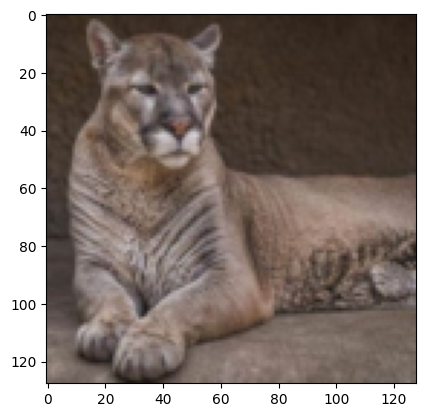

In [16]:
import matplotlib.pyplot as plt
num_img = 0
test_img = np.array(train_dataset[num_img][0]).transpose(1, 2, 0)[..., ::-1]
print(f'Class id: {train_dataset[num_img][1]} Class name: {target_names[train_dataset[num_img][1]]}')
plt.imshow(test_img)

# DataLoader

In [17]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for images, targets in train_loader:
    print(images.shape, targets.shape)
    break

torch.Size([128, 3, 128, 128]) torch.Size([128])


# Models

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# Модель полносвязной сети
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        X = X.flatten(start_dim=1)
        out = F.relu(self.fc1(X))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Простейшая модель сверточных нейронных сетей
class CNN(nn.Module):
    def __init__(self, img_size):
        super(CNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Полносвязные слои
        self.fc1 = nn.Linear(img_size[0]//4*img_size[1]//4 * 32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [21]:
import time
learning_rate = 0.001
num_epochs = 101
input_dim = np.prod(img_size)
hidden_dim = 256
output_dim = 10

# MLP
model = NN(input_dim, hidden_dim, output_dim).to(device)

# CNN
# model = CNN(img_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

st = time.time()
for epoch in range(num_epochs):
    loss_train = []
    for i, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())

    if epoch%10==0:
        print(f'Epoch: {epoch} | Error: {np.mean(loss_train)}')

print(f'Elapsed Time: {time.time()-st} s')

Epoch: 0 | Error: 3.6784292522229647
Epoch: 10 | Error: 1.9689572735836631
Epoch: 20 | Error: 1.517791459434911
Epoch: 30 | Error: 1.3842456560385854
Epoch: 40 | Error: 0.5814620099569622
Epoch: 50 | Error: 0.4732536218668285
Epoch: 60 | Error: 0.3001584567521748
Epoch: 70 | Error: 1.673308723851254
Epoch: 80 | Error: 0.8105393052101135
Epoch: 90 | Error: 0.6124885380268097
Epoch: 100 | Error: 0.7341259200322
Elapsed Time: 416.6547739505768 s


In [22]:
def get_accuracy(data_loader, model):
    acc = 0
    for i, (images, targets) in enumerate(data_loader):
        images, targets = images.to(device), targets.to(device)
        pred = model(images)
        result = torch.argmax(pred, dim=1)
        acc += torch.sum(result==targets).item()
    return acc

acc_train = get_accuracy(train_loader, model)
print(f'Accuracy Train: {np.round(acc_train/len(train_dataset)*100,2)}%')

acc_test = get_accuracy(test_loader, model)
print(f'Accuracy Test: {np.round(acc_test/len(test_dataset)*100,2)}%')

Accuracy Train: 71.48%
Accuracy Test: 30.0%


In [35]:
# Сохранение модели с обученными весами в файл
# torch.save(model, 'model_weights.pth')

# Загрузка модели
# model_load = torch.load('model_weights.pth')

# Predict and visualize one image

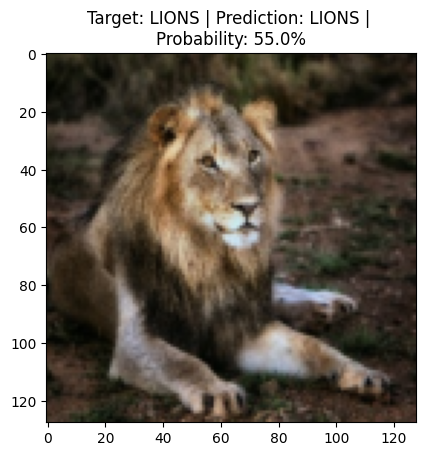

In [23]:
import matplotlib.pyplot as plt
num_img = 30

image, target = test_dataset[num_img][0].to(device), test_dataset[num_img][0].to(device)
output = model(image[None,...])
pred = torch.argmax(output)
probability = torch.max(F.softmax(model(image[None,...]), dim=1))

plt.title(f'Target: {target_names[test_dataset[num_img][1]]} | '
          f'Prediction: {target_names[pred]} | \n'
          f'Probability: {torch.round(probability*100)}%')
test_img = np.array(test_dataset[num_img][0]).transpose(1, 2, 0)[..., ::-1]
plt.imshow(test_img)

# ДЗ

## Обучить модель на собственном наборе данных:
1) выберите набор данных для решения задачи классификации;
2) используя PyTorch, создайте модель нейронной сети для обучения на выбранном наборе данных;
3) обучите модель, оцените ее точность на обучающей и тестовой выборках;
4) постройте графики зависимости ошибки от кол-ва эпох;
5) подберите параметры модели, если это необходимо, чтобы улучшить ее результаты.